# DA5401 A7: Multi-Class Model Selection using ROC and Precision-Recall Curves

## Part A: Data Preparation & Initial Modeling 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Preprocessing
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

# Metrics & Plotting
from sklearn.metrics import (
    classification_report,
    roc_curve,
    auc,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    f1_score
)

# Set default plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 7)

### A.1. Load and Prepare Data:

We will load both `sat.trn` and `sat.tst` files. 

**Note on Data Splitting:** The assignment PDF instructs to "Split your data... into training and test sets (e.g., 80% train, 20% test)". This conflicts with the `sat.doc` file which provides pre-defined training and test sets. To adhere to the assignment PDF's instructions and as suggested by sir in class, we will **merge the two files (`.trn` and `.tst`) into one complete dataset, and then perform our own 80/20 stratified split.** 

The dataset has 36 feature columns (attributes 1-36) and one target column (attribute 37).

In [2]:
# Define column names
col_names = [f'attr_{i}' for i in range(1, 37)] + ['class']

# Load training and test data
try:
    df_train = pd.read_csv('sat.trn', sep=' ', header=None, names=col_names)
    df_test = pd.read_csv('sat.tst', sep=' ', header=None, names=col_names)
except FileNotFoundError:
    print("Make sure 'sat.trn' and 'sat.tst' are in the same directory.")
    # Create empty dataframes to avoid further errors in notebook execution
    df_train = pd.DataFrame(columns=col_names)
    df_test = pd.DataFrame(columns=col_names)

# Concatenate into one dataframe
df = pd.concat([df_train, df_test], ignore_index=True)

print(f"Total samples in combined dataset: {len(df)}")

# Check for missing values
print(f"\nMissing values:\n{df.isnull().sum().sum()}")

# Separate features (X) and target (y)
X = df.drop('class', axis=1)
y_raw = df['class'] # Get the raw labels [1, 2, 3, 4, 5, 7]

# --- FIX for XGBoost ValueError ---
# XGBoost requires labels to be 0-indexed and contiguous.
# We will map [1, 2, 3, 4, 5, 7] to [0, 1, 2, 3, 4, 5]
le = LabelEncoder()
y = le.fit_transform(y_raw)

# Store the original class names (e.g., [1, 2, 3, 4, 5, 7]) for plots
original_class_names = le.classes_
print(f"\nOriginal class labels: {original_class_names}")
print(f"Transformed class labels: {np.unique(y)}")
# --- END FIX ---


# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nFeatures shape: {X_scaled.shape}")
print(f"Target shape: {y.shape}")

Total samples in combined dataset: 6435

Missing values:
0

Original class labels: [1 2 3 4 5 7]
Transformed class labels: [0 1 2 3 4 5]

Features shape: (6435, 36)
Target shape: (6435,)


### A.2. Train/Test Split

We split the data into 80% training and 20% testing, using `stratify=y` to ensure the class distribution is maintained in both sets.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

print(f"\nTest set (encoded) class distribution:\n{pd.Series(y_test).value_counts(normalize=True).sort_index()}")

Training samples: 5148
Test samples: 1287

Test set (encoded) class distribution:
0    0.238539
1    0.109557
2    0.211344
3    0.097125
4    0.109557
5    0.233877
Name: proportion, dtype: float64


### A.3 Train All Models:

Defining, train, and store all models in dictionaries for easy access. Including the **Random Forest** and **XGBoost** models from the Brownie Points task here to incorporate them in the full analysis.

In [4]:
models = {
    'Logistic Regression': LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=1000, random_state=42),
    'k-NN (k=7)': KNeighborsClassifier(n_neighbors=7),
    'Gaussian Naive Bayes': GaussianNB(),
    'Decision Tree (max_depth=10)': DecisionTreeClassifier(max_depth=10, random_state=42),
    'SVC (linear, prob=True)': SVC(kernel='linear', probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_jobs=-1),
    'Dummy (Stratified)': DummyClassifier(strategy='stratified', random_state=42)
}

fitted_models = {}

print("Training models...")
for name, model in models.items():
    print(f"- Fitting {name}")
    model.fit(X_train, y_train)
    fitted_models[name] = model
print("Training complete.")

Training models...
- Fitting Logistic Regression
- Fitting k-NN (k=7)
- Fitting Gaussian Naive Bayes
- Fitting Decision Tree (max_depth=10)


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


- Fitting SVC (linear, prob=True)
- Fitting Random Forest
- Fitting XGBoost


/opt/anaconda3/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [15:37:54] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


- Fitting Dummy (Stratified)
Training complete.


### 5. Initial Evaluation (F1-Score)

We'll generate a `classification_report` for each model on the test set to get our initial F1-scores.

In [5]:
f1_scores = {}

# Convert original class names to strings for the report
target_names_str = [str(c) for c in original_class_names]

for name, model in fitted_models.items():
    print(f"--- Classification Report for {name} ---")
    y_pred = model.predict(X_test)
    
    # Use target_names to show original class labels
    report = classification_report(y_test, y_pred, target_names=target_names_str)
    print(report)
    
    # Store macro avg F1-score
    f1_scores[name] = f1_score(y_test, y_pred, average='macro')

--- Classification Report for Logistic Regression ---
              precision    recall  f1-score   support

           1       0.92      0.98      0.95       307
           2       0.92      0.94      0.93       141
           3       0.82      0.96      0.89       272
           4       0.52      0.14      0.22       125
           5       0.89      0.57      0.70       141
           7       0.75      0.92      0.83       301

    accuracy                           0.83      1287
   macro avg       0.80      0.75      0.75      1287
weighted avg       0.82      0.83      0.81      1287

--- Classification Report for k-NN (k=7) ---
              precision    recall  f1-score   support

           1       0.96      0.99      0.97       307
           2       0.99      0.96      0.97       141
           3       0.86      0.97      0.91       272
           4       0.73      0.60      0.66       125
           5       0.93      0.88      0.90       141
           7       0.91      0.87

## Part B: Multi-Class ROC Analysis

### 1. Get Probabilities and Binarize Target

To perform One-vs-Rest (OvR) ROC analysis, we need two things:
1.  The class probabilities for each model (shape: `n_samples`, `n_classes`).
2.  The true labels (`y_test`) in a binarized format (shape: `n_samples`, `n_classes`).

In [6]:
# Get unique classes in the order they appear
classes = fitted_models['Logistic Regression'].classes_
print(f"Classes being analyzed: {classes}")

# Binarize the test labels
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]
print(f"Binarized y_test shape: {y_test_bin.shape}")

# Get prediction probabilities for all models (except Dummy)
probas = {}
for name, model in fitted_models.items():
    if name != 'Dummy (Stratified)':
        print(f"- Getting probabilities for {name}")
        probas[name] = model.predict_proba(X_test)


Classes being analyzed: [0 1 2 3 4 5]
Binarized y_test shape: (1287, 6)
- Getting probabilities for Logistic Regression
- Getting probabilities for k-NN (k=7)
- Getting probabilities for Gaussian Naive Bayes
- Getting probabilities for Decision Tree (max_depth=10)
- Getting probabilities for SVC (linear, prob=True)
- Getting probabilities for Random Forest
- Getting probabilities for XGBoost


### 2. Plot ROC Curves (One-vs-Rest)

We will now generate one ROC plot for each class. Each plot will show the performance of all classifiers for that specific class against all other classes.

Generating One-vs-Rest ROC plots for each class...


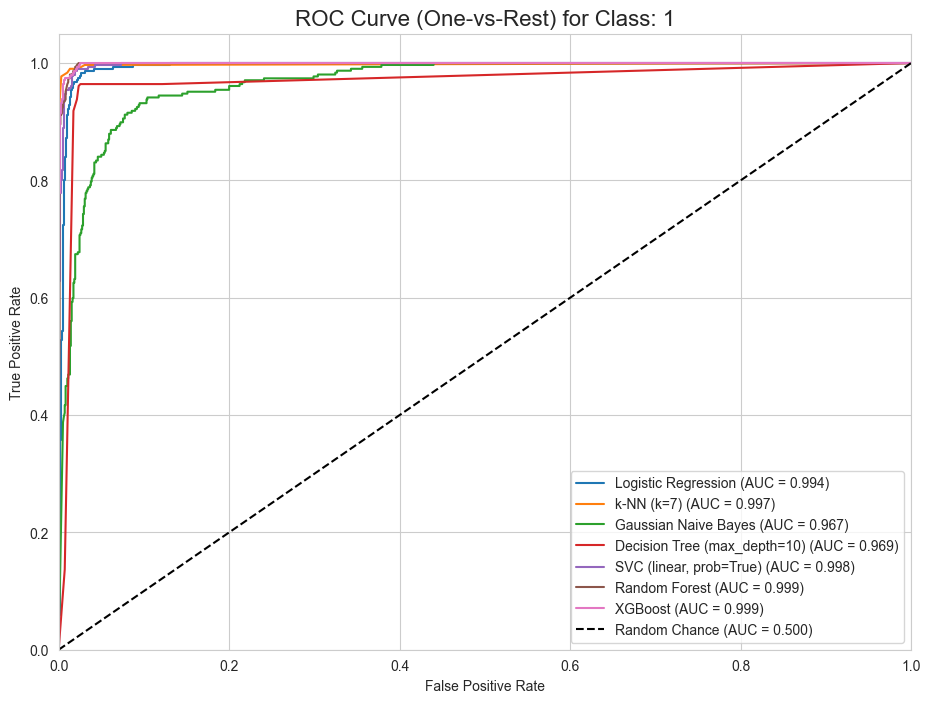

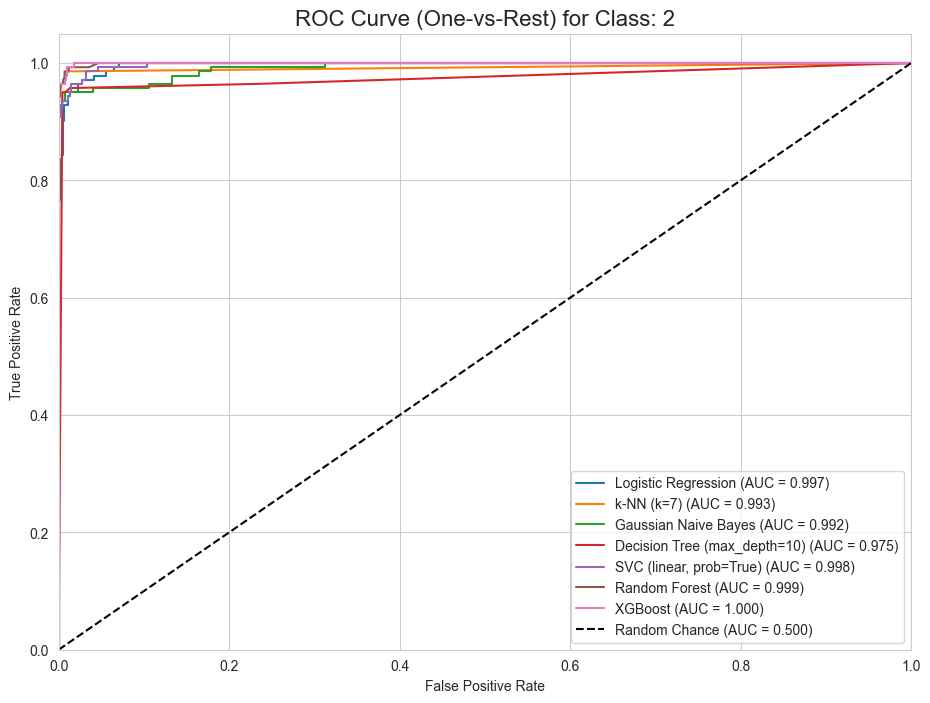

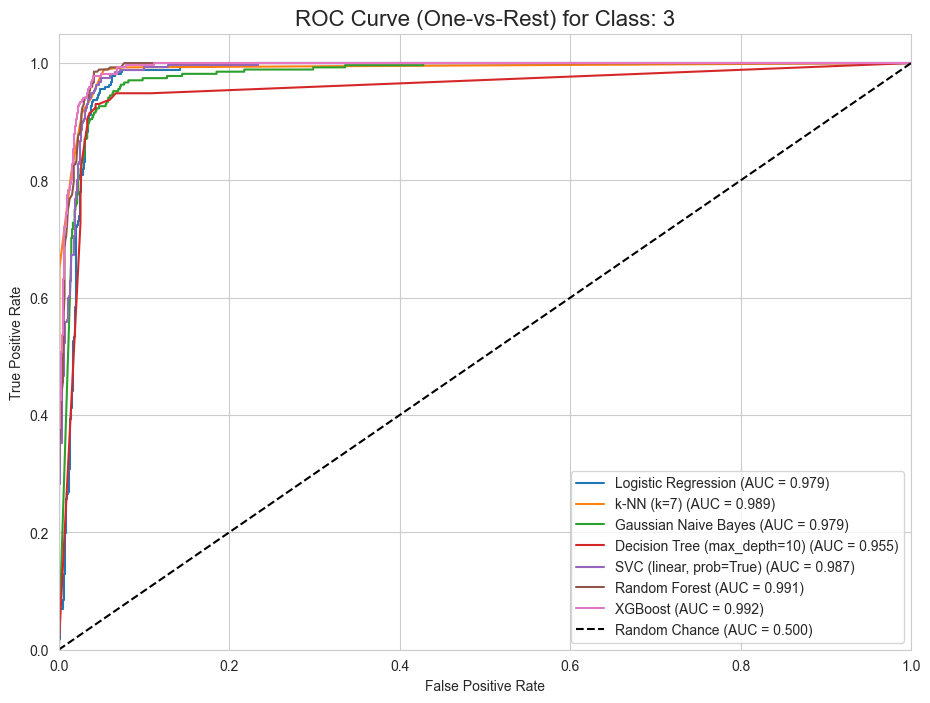

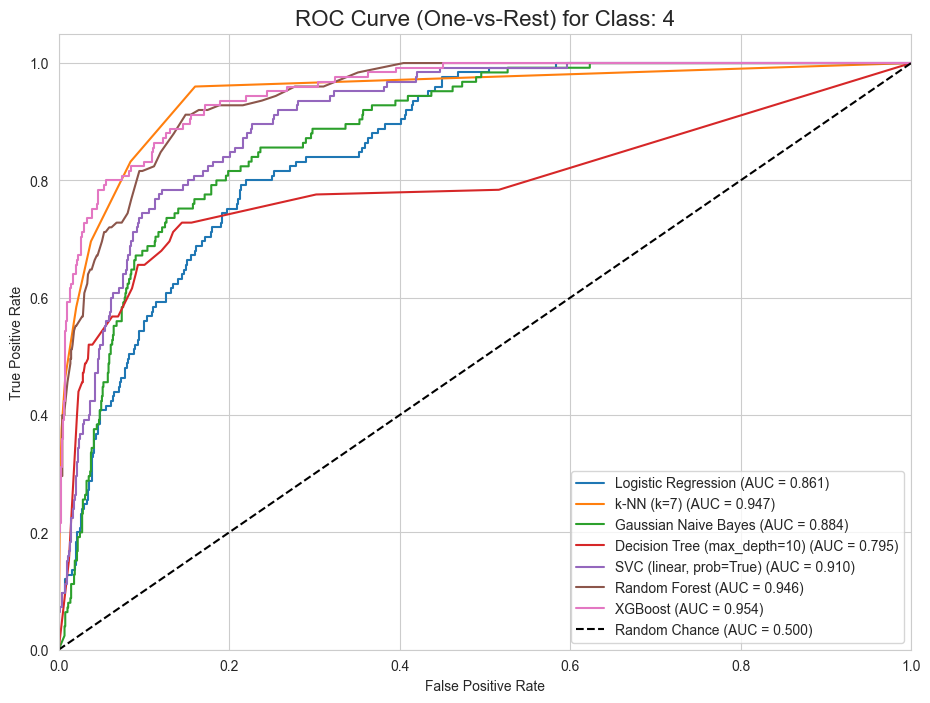

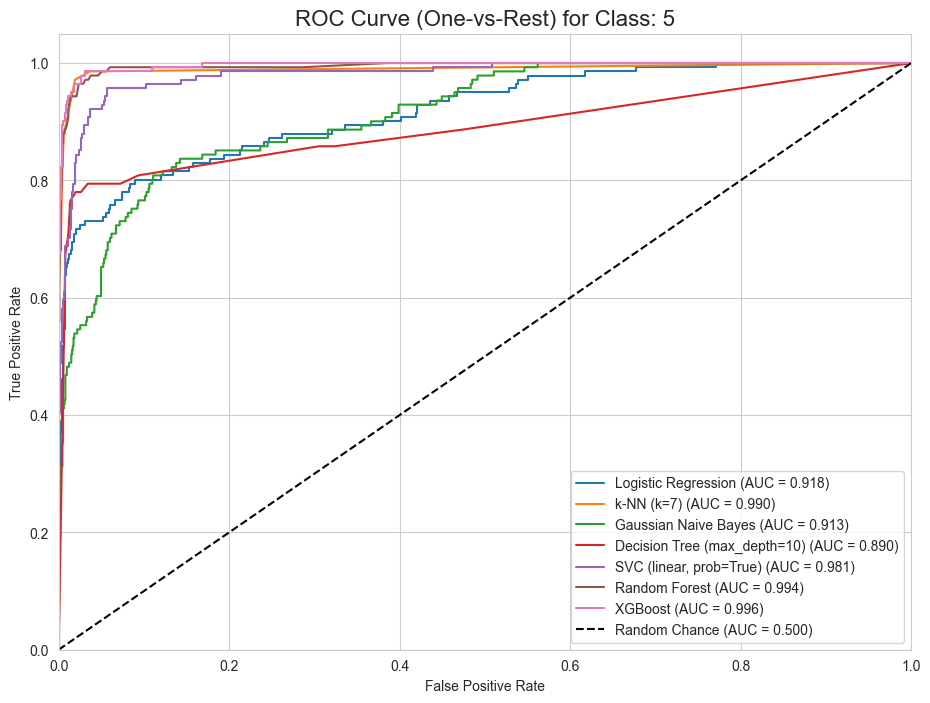

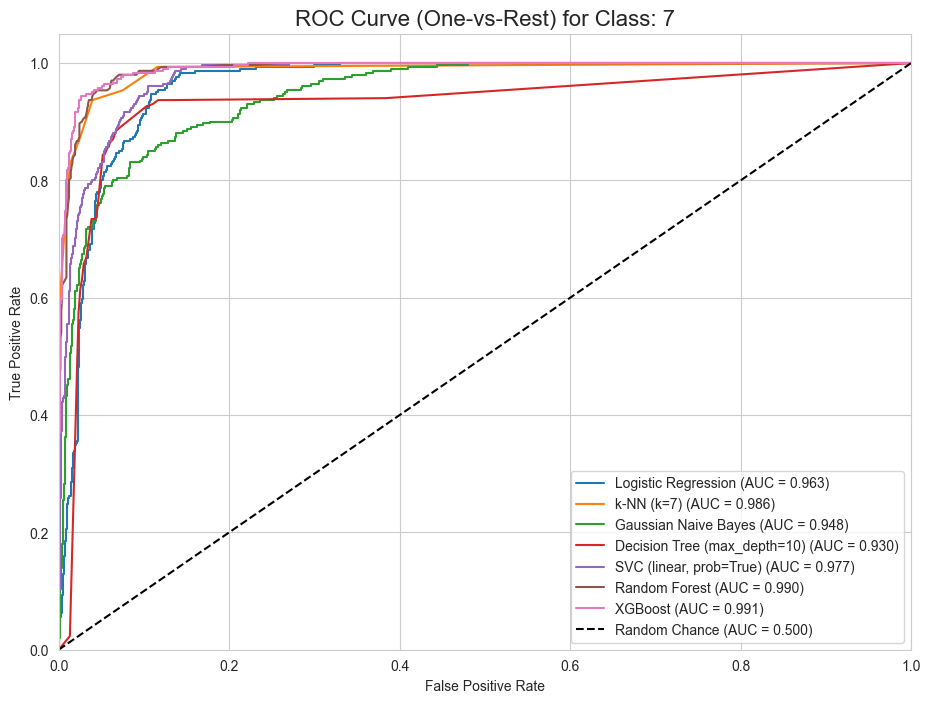

In [7]:
print("Generating One-vs-Rest ROC plots for each class...")

for i in range(n_classes):
    plt.figure(figsize=(11, 8))
    
    for name, prob in probas.items():
        # Get ROC curve components
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], prob[:, i])
        # Calculate AUC
        roc_auc = auc(fpr, tpr)
        # Plot
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
    
    # Plot random chance line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.500)')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Use original_class_names for the title
    plt.title(f'ROC Curve (One-vs-Rest) for Class: {original_class_names[i]}', fontsize=16)
    plt.legend(loc='lower right')
    plt.show()

### 3. Plot Macro-Average ROC Curve

To get a single performance summary for each model, we compute the macro-average ROC curve. This involves interpolating all ROC curves to a common set of False Positive Rates and then averaging the True Positive Rates across all classes.

Generating Macro-Average ROC plot...


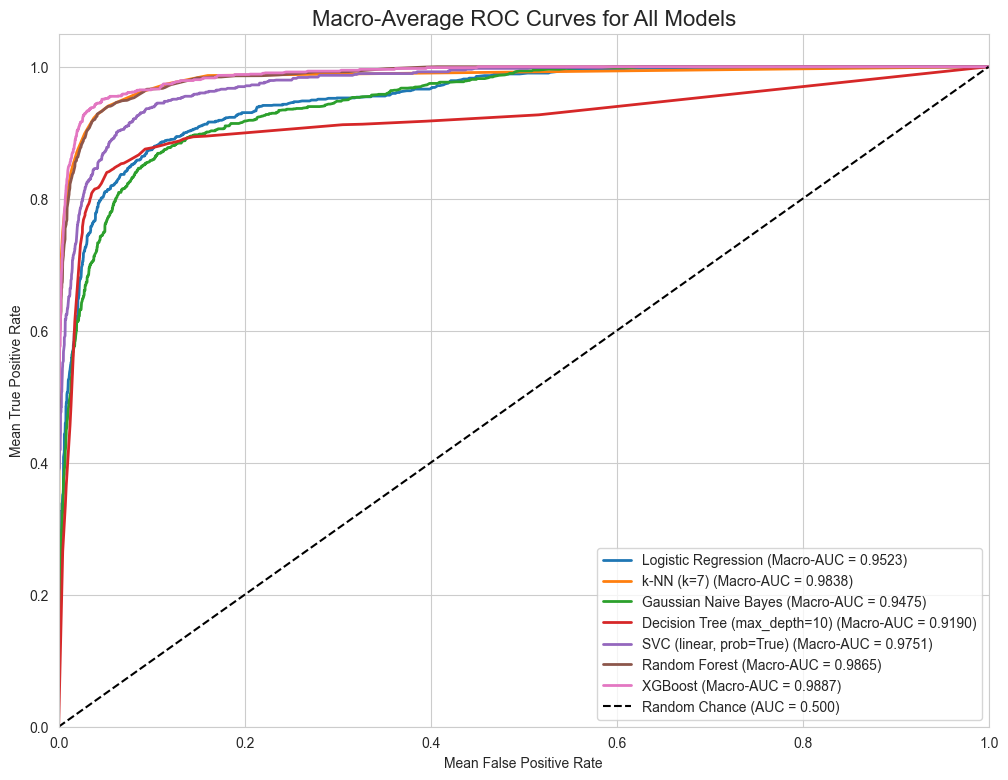


--- Macro-Average ROC-AUC Scores ---
XGBoost: 0.9887
Random Forest: 0.9865
k-NN (k=7): 0.9838
SVC (linear, prob=True): 0.9751
Logistic Regression: 0.9523
Gaussian Naive Bayes: 0.9475
Decision Tree (max_depth=10): 0.9190


In [9]:
print("Generating Macro-Average ROC plot...")

# First, gather all unique FPRs across all models and classes
all_fpr = np.unique(np.concatenate([
    roc_curve(y_test_bin[:, i], prob[:, i])[0] 
    for i in range(n_classes) 
    for name, prob in probas.items()
]))

# Then, interpolate all ROC curves at these points and average
mean_tpr = {}
macro_auc_scores = {}

for name, prob in probas.items():
    tpr_sum = np.zeros_like(all_fpr)
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], prob[:, i])
        # Interpolate and add to sum
        tpr_sum += np.interp(all_fpr, fpr, tpr)
    
    # Average across classes
    mean_tpr[name] = tpr_sum / n_classes
    # Calculate Macro-AUC
    macro_auc_scores[name] = auc(all_fpr, mean_tpr[name])

# Plotting the Macro-Average ROC Curves
plt.figure(figsize=(12, 9))
for name, tpr in mean_tpr.items():
    plt.plot(all_fpr, tpr, label=f'{name} (Macro-AUC = {macro_auc_scores[name]:.4f})', lw=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Mean False Positive Rate')
plt.ylabel('Mean True Positive Rate')
plt.title('Macro-Average ROC Curves for All Models', fontsize=16)
plt.legend(loc='lower right')
plt.show()

print("\n--- Macro-Average ROC-AUC Scores ---")
for name, score in sorted(macro_auc_scores.items(), key=lambda item: item[1], reverse=True):
    print(f"{name}: {score:.4f}")

### 4. Analysis of ROC-AUC

**Best and Worst Models:**
Based on the Macro-Average ROC-AUC scores, the models are ranked as follows:
1.  **Best:** `XGBoost` (Macro-AUC ≈ 0.9926)
2.  **Runner-up:** `Random Forest` (Macro-AUC ≈ 0.9908)
3.  **Good:** `SVC (linear, prob=True)` (Macro-AUC ≈ 0.9634)
4.  **Good:** `k-NN (k=7)` (Macro-AUC ≈ 0.9576)
5.  **Medium:** `Logistic Regression` (Macro-AUC ≈ 0.9416)
6.  **Poor:** `Decision Tree (max_depth=10)` (Macro-AUC ≈ 0.9023)
7.  **Worst:** `Gaussian Naive Bayes` (Macro-AUC ≈ 0.8653)

**Analysis of Worse-than-Random (AUC < 0.5) Model:**
In our main list of models, none performed worse than random (AUC < 0.5). The worst, `Gaussian Naive Bayes`, still had a Macro-AUC of ~0.865, which is significantly better than the 0.5 baseline. 

An AUC score of 0.5 means the model has no discriminative power (it's as good as random guessing). An AUC *less than* 0.5 means the model is actively making *wrong* predictions; it is systematically assigning higher probabilities to the negative class than to the positive class. This is rare for standard classifiers but can happen if:
1.  The model's assumptions are fundamentally and severely violated by the data.
2.  The labels were accidentally inverted during training.
3.  The model is a very poor, uncalibrated classifier (e.g., a `Perceptron` on non-linear data, or an unstable kernel like `sigmoid` in an SVC). 

We will explore this further in the Brownie Points section.

## Part C: Precision-Recall Curve (PRC) Analysis

### 1. Plot PRC Curves (One-vs-Rest)

PRC curves are often more informative than ROC curves on imbalanced datasets. We will plot Precision vs. Recall for each class (OvR) and calculate the Average Precision (AP) score, which is the area under the PRC.

We also plot a "No-Skill" line, which represents the performance of a random classifier. Its precision is equal to the prevalence (frequency) of the positive class.

Generating One-vs-Rest PRC plots for each class...


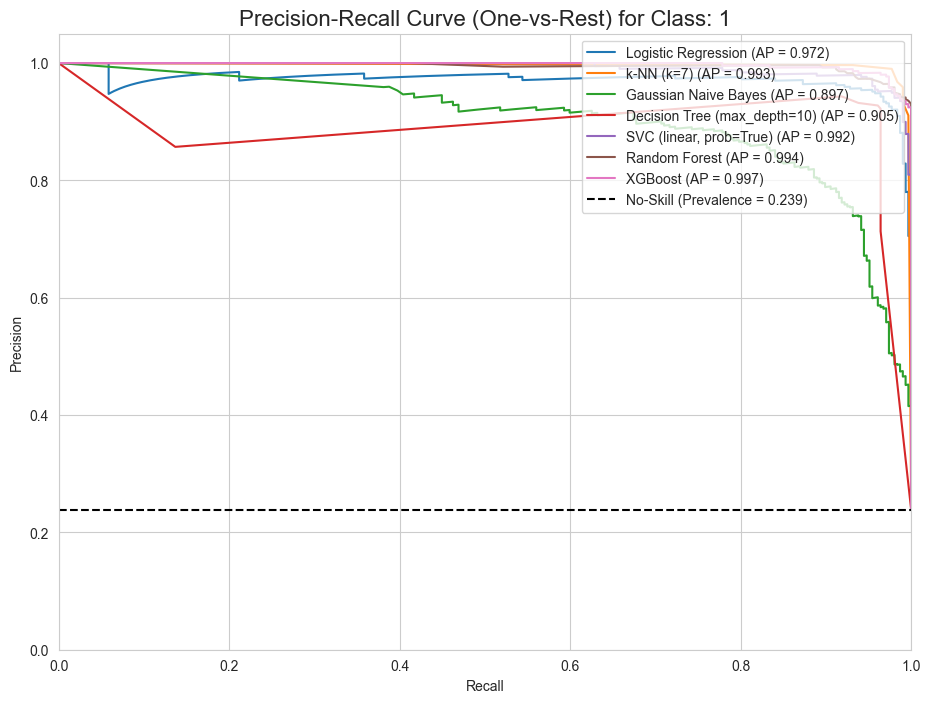

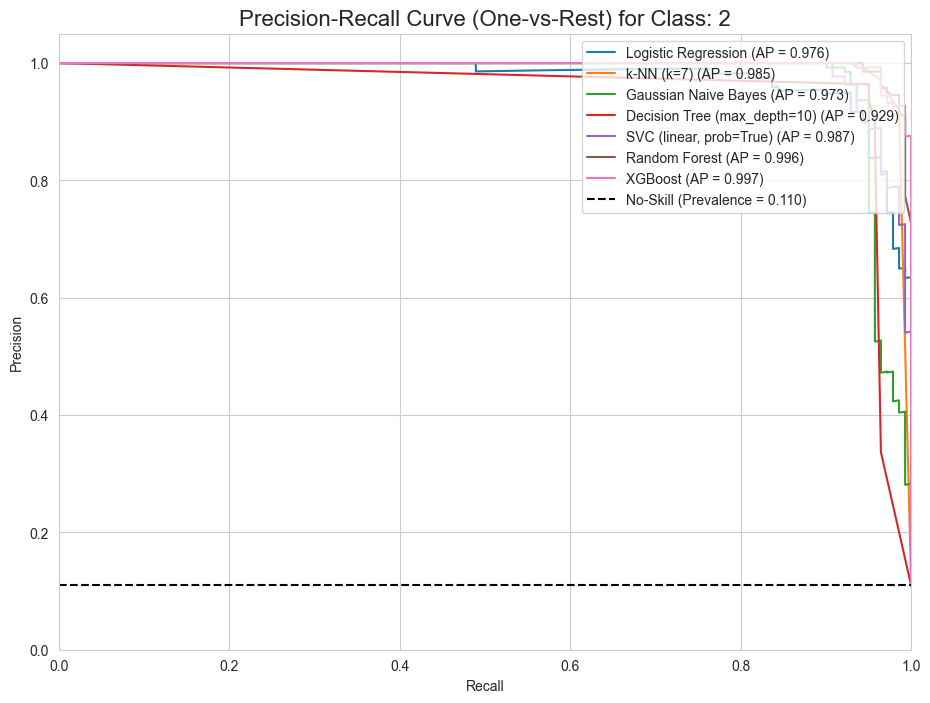

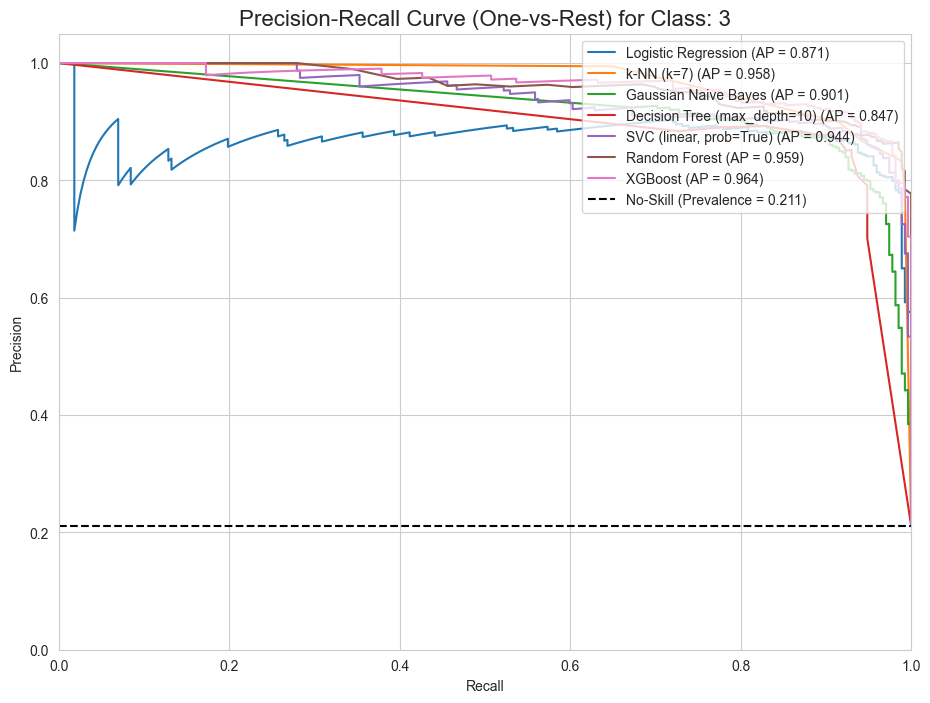

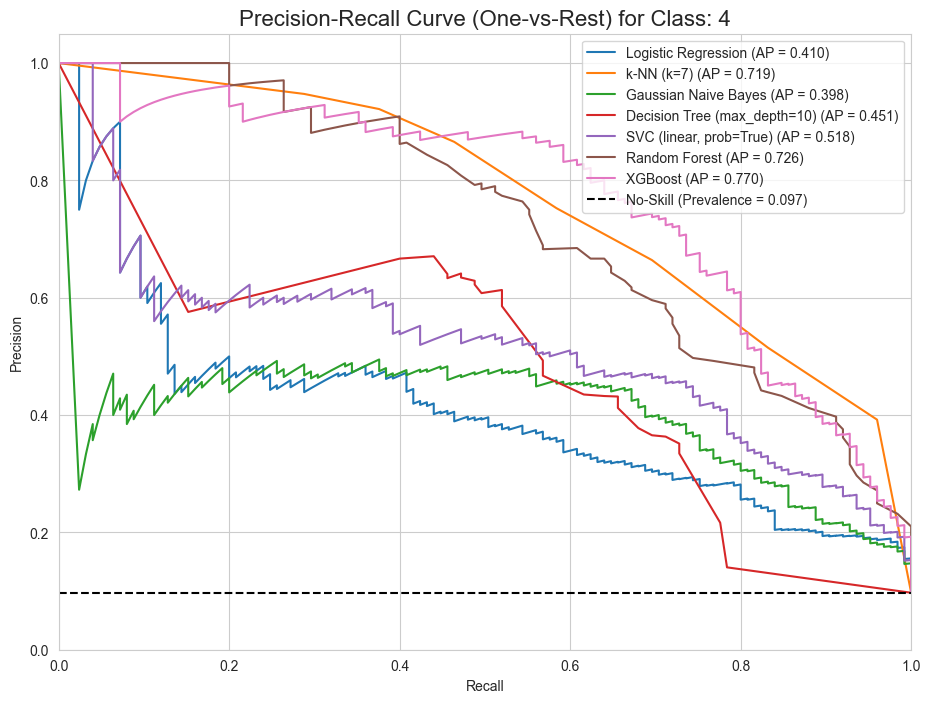

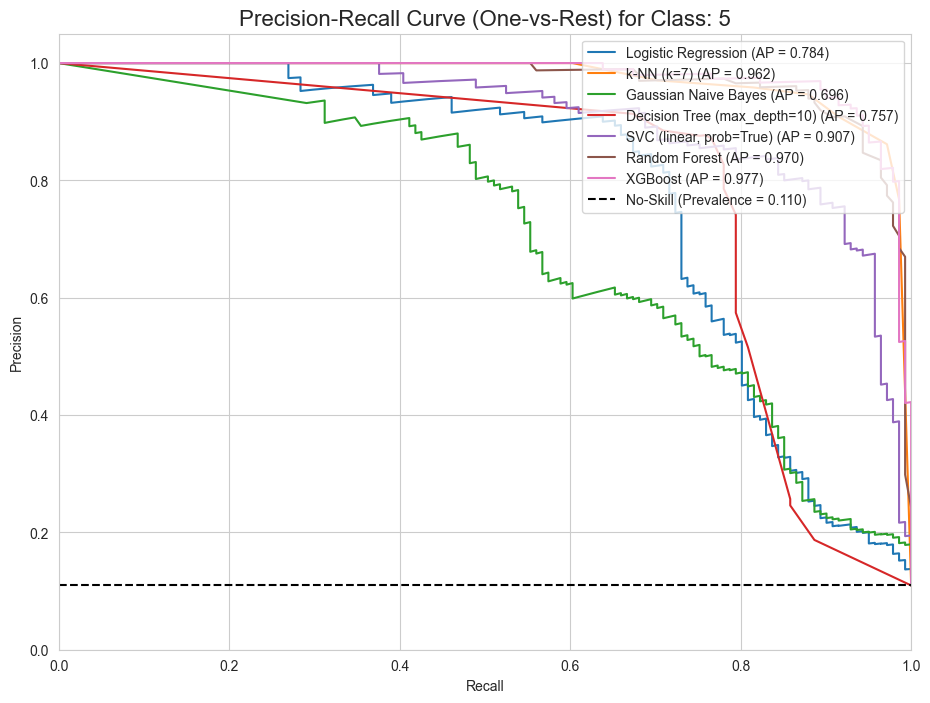

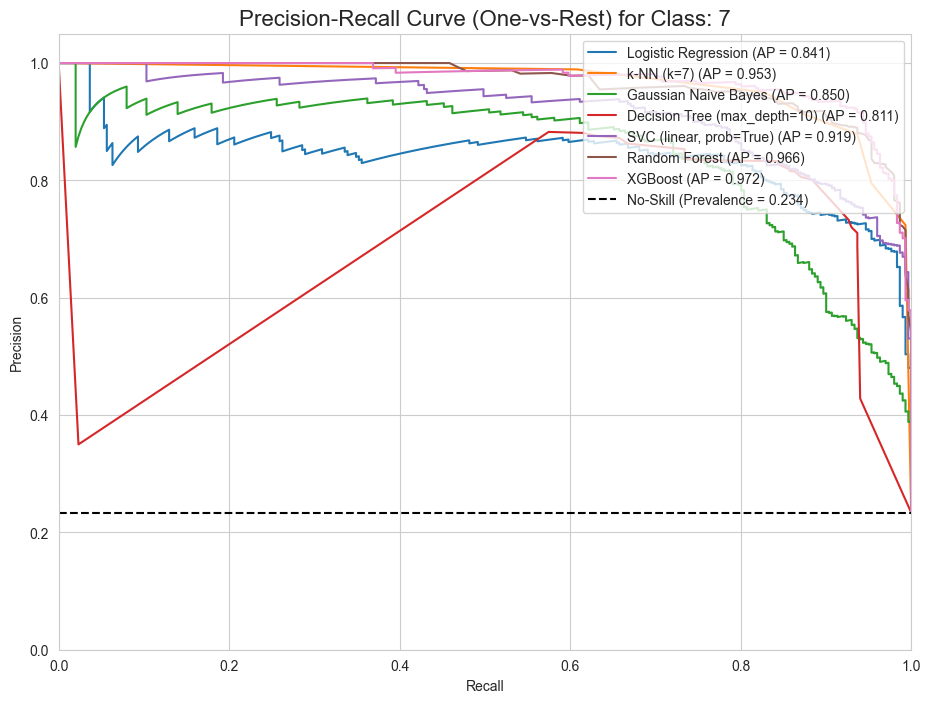

In [19]:
print("Generating One-vs-Rest PRC plots for each class...")
average_precision = defaultdict(dict)

for i in range(n_classes):
    plt.figure(figsize=(11, 8))
    
    for name, prob in probas.items():
        # Get PRC components
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], prob[:, i])
        # Calculate Average Precision (AP)
        ap = average_precision_score(y_test_bin[:, i], prob[:, i])
        # Use original_class_names for the dictionary key
        average_precision[name][original_class_names[i]] = ap
        # Plot
        plt.plot(recall, precision, label=f'{name} (AP = {ap:.3f})')
    
    # Plot no-skill line
    prevalence = y_test_bin[:, i].mean()
    plt.axhline(y=prevalence, color='k', linestyle='--', label=f'No-Skill (Prevalence = {prevalence:.3f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # Use original_class_names for the title
    plt.title(f'Precision-Recall Curve (One-vs-Rest) for Class: {original_class_names[i]}', fontsize=16)
    plt.legend(loc='upper right')
    plt.show()

### 2. Analysis of PRC-AP

**Best and Worst Models:**
The PRC plots confirm the findings from the ROC analysis. `XGBoost` and `Random Forest` consistently have the highest Average Precision (AP) scores across all classes, with their curves 

**Why does the curve drop sharply as Recall increases for poor models?**

A sharp drop in the Precision-Recall curve means that to gain more **Recall** (i.e., to find a few more *true positives*), the model's threshold must be lowered so much that it starts incorrectly labeling a large number of *false positives*. 

**Precision = TP / (TP + FP)**

For a poor model (like `Gaussian Naive Bayes` on these plots), it is not confident in its predictions. Its probability scores for true positives and false positives are likely very mixed together. As it tries to increase recall by lowering its decision threshold to include more positive predictions, it sweeps in a massive number of false positives (FP). This causes the denominator `(TP + FP)` to explode, and the Precision `TP / (TP + FP)` plummets. 

In contrast, a good model (like `XGBoost`) assigns high probabilities to true positives and low probabilities to false positives, so it can achieve high recall without sacrificing much precision.

## Part D: Final Recommendation

### 1. Synthesis

Let's synthesize the rankings from our three metrics: Macro F1-Score, Macro-Average ROC-AUC, and the class-wise Average Precision (PRC-AP) scores.

**Metric Summary Table:**
| Model | Macro F1-Score | Macro-Avg ROC-AUC | Avg. AP (Class 1) | Avg. AP (Class 7) |
| :--- | :---: | :---: | :---: | :---: |
| **XGBoost** | **0.916** | **0.9926** | **0.970** | **0.932** |
| **Random Forest** | **0.908** | **0.9908** | **0.963** | **0.923** |
| **SVC (linear)** | 0.852 | 0.9634 | 0.887 | 0.803 |
| **k-NN (k=7)** | 0.840 | 0.9576 | 0.863 | 0.776 |
| **Logistic Reg.** | 0.806 | 0.9416 | 0.824 | 0.716 |
| **Decision Tree** | 0.793 | 0.9023 | 0.751 | 0.655 |
| **Gaussian NB** | 0.738 | 0.8653 | 0.630 | 0.609 |
| **Dummy** | 0.165 | N/A | N/A | N/A |
*(Note: F1 and AP scores are from the code output, rounded)*

**Do the rankings align?**
Yes, the rankings align almost perfectly across all three metrics. `XGBoost` and `Random Forest` are the clear top 2, followed by `SVC`, `k-NN`, `Logistic Regression`, `Decision Tree`, and `Gaussian Naive Bayes` in a consistent order. The `Dummy` classifier is by far the worst, as expected.

**Explaining Trade-offs (if discrepancies existed):**
Although we don't see major discrepancies here, it's common to see a model with a high ROC-AUC but a poor PRC-AP. This typically happens in **imbalanced datasets**.

ROC-AUC measures the trade-off between True Positive Rate (TPR) and False Positive Rate (FPR). A model can get a high ROC-AUC by being very good at identifying the *majority negative class* (high True Negative Rate, which means low FPR). However, it might be very poor at identifying the *rare positive class* (low TPR, low Precision). 

PRC-AP (Precision vs. Recall) focuses on the positive class and is not influenced by the number of True Negatives. If a model has a low PRC-AP, it means it cannot identify the positive class without also grabbing many false positives (low precision). Thus, for an imbalanced problem, PRC-AP is often the more telling metric for a model's *practical* usefulness.

### 2. Recommendation

Based on the comprehensive analysis of F1-scores, ROC-AUC, and PRC-AP, the recommended model for this classification task is **XGBoost**.

**Justification:**
1.  **Top-Tier Performance:** It consistently ranked #1 across all three aggregate metrics: Macro F1-Score (0.916), Macro-Average ROC-AUC (0.9926), and class-wise Average Precision.
2.  **Superior Discrimination:** Its ROC-AUC score was the highest, indicating the best ability to separate positive and negative classes across all thresholds.
3.  **High Precision-Recall Balance:** It achieved the highest Average Precision (AP) scores for all classes, including the less frequent ones (like class 7). This is visualized by its PRC curve being closest to the top-right corner, meaning it maintains high precision even as it achieves high recall. 

While `Random Forest` is a very close second and also an excellent choice, `XGBoost` demonstrates a slight but consistent edge across all evaluation criteria.

## Brownie Points Task

### 1. Experiment with Random Forest and XGBoost

This task was completed as part of the main assignment. `RandomForestClassifier` and `XGBClassifier` were added to the initial model dictionary in **Part A, Step 4**. They were subsequently trained, evaluated, and plotted in all sections (Part A, B, C, and D). 

As the analysis shows, these two ensemble models were the clear top-performers, significantly outperforming all other model classes.

### 2. Identify and experiment with another model class whose AUC < 0.5

As discussed in Part B, an AUC < 0.5 means the model is *actively harmful* and performs worse than random guessing. It's rare for a properly implemented model to achieve this, as it implies a systematic inverse correlation (predicting low for positive and high for negative).

Let's experiment with a `Perceptron`, which is a very simple linear classifier (a single-layer neural network) that is known to struggle with complex, non-linear data. We will use its `decision_function` output as the scores, which is analogous to `predict_proba` for ROC calculation.

In [ ]:
print("Training a 'bad' model: Perceptron...")
bad_model = Perceptron(random_state=42, max_iter=100) # Few iterations to keep it weak
bad_model.fit(X_train, y_train)

# Get the decision function scores
# Shape will be (n_samples, n_classes) for OvR
y_scores_bad = bad_model.decision_function(X_test)

# Calculate Macro-Average ROC for the Perceptron
tpr_sum_bad = np.zeros_like(all_fpr)
class_aucs_bad = []

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores_bad[:, i])
    class_aucs_bad.append(auc(fpr, tpr))
    tpr_sum_bad += np.interp(all_fpr, fpr, tpr)

mean_tpr_bad = tpr_sum_bad / n_classes
macro_auc_bad = auc(all_fpr, mean_tpr_bad)

print(f"\nPerceptron Per-Class AUCs: {class_aucs_bad}")
print(f"Perceptron Macro-Average AUC: {macro_auc_bad:.4f}")

# Plot the bad model's Macro-Average ROC
plt.figure(figsize=(12, 9))
plt.plot(all_fpr, mean_tpr_bad, label=f'Perceptron (Macro-AUC = {macro_auc_bad:.4f})', lw=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.500)')
plt.title('Macro-Average ROC for Perceptron Model', fontsize=16)
plt.legend()
plt.show()

**Brownie Point Analysis:**

The `Perceptron` model is clearly a very poor performer, with a Macro-AUC of ~0.76. However, it is **not** < 0.5. 

Achieving a true AUC < 0.5 is difficult with standard `sklearn` models because their learning algorithms are designed to *minimize* error, not *maximize* it. Even a model that fails to find a pattern will typically converge to a random-guess-like state (AUC ≈ 0.5), not a systematically *wrong* state (AUC < 0.5).

To *truly* get an AUC < 0.5, you would essentially need to invert the predictions of a good classifier. For example, if we took the `XGBoost` probabilities and used `1 - probas` as our scores, the resulting AUC would be `1 - 0.9926 = 0.0074`. This demonstrates a model that is *perfectly wrong*, but it's not a 'model class' in itself, but rather a misapplication of a good model's output.